In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re  
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import Dataset
from sacrebleu import corpus_bleu
import pickle as pkl
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load pre-trained embeddings

In [3]:
path_vi = '../iwslt-vi-en-processed/'

PAD_token = 0
UNK_token = 1
SOS_token = 2
EOS_token = 3

EMBED_SIZE = 300
words_to_load = 100000

with open('/scratch/xm576/wiki-news-300d-1M.vec') as f:
    matrix_size = words_to_load + 4
    loaded_embeddings_ft_en = np.zeros((matrix_size, EMBED_SIZE))
    words_ft_en = {'<pad>': PAD_token, '<unk>': UNK_token, '<sos>': SOS_token, '<eos>': EOS_token,}
    idx2words_ft_en = {PAD_token: '<pad>', UNK_token: '<unk>', SOS_token: '<sos>', EOS_token: '<eos>'}
    ordered_words_ft_en = ['<pad>', '<unk>', '<sos>', '<eos>']
    
    loaded_embeddings_ft_en[0,:] = np.zeros(EMBED_SIZE)
    loaded_embeddings_ft_en[1,:] = np.random.uniform(-1.0, 1.0, EMBED_SIZE)
    loaded_embeddings_ft_en[2,:] = np.random.uniform(-1.0, 1.0, EMBED_SIZE)
    loaded_embeddings_ft_en[3,:] = np.random.uniform(-1.0, 1.0, EMBED_SIZE)
    
    for i, line in enumerate(f):
        if i == 0:
            continue
        if i == words_to_load + 1: 
            break
        s = line.split()
        idx = i + 3
        loaded_embeddings_ft_en[idx, :] = np.asarray(s[1:])
        words_ft_en[s[0]] = idx
        idx2words_ft_en[idx] = s[0]
        ordered_words_ft_en.append(s[0])

with open('/scratch/xm576/cc.vi.300.vec') as f:
    matrix_size = words_to_load + 4
    loaded_embeddings_ft_zh = np.zeros((matrix_size, EMBED_SIZE))
    words_ft_zh = {'<pad>': PAD_token, '<unk>': UNK_token, '<sos>': SOS_token, '<eos>': EOS_token,}
    idx2words_ft_zh = {PAD_token: '<pad>', UNK_token: '<unk>', SOS_token: '<sos>', EOS_token: '<eos>'}
    ordered_words_ft_zh = ['<pad>', '<unk>', '<sos>', '<eos>']
    
    loaded_embeddings_ft_zh[0,:] = np.zeros(EMBED_SIZE)
    loaded_embeddings_ft_zh[1,:] = np.random.uniform(-1.0, 1.0, EMBED_SIZE)
    loaded_embeddings_ft_zh[2,:] = np.random.uniform(-1.0, 1.0, EMBED_SIZE)
    loaded_embeddings_ft_zh[3,:] = np.random.uniform(-1.0, 1.0, EMBED_SIZE)
    
    for i, line in enumerate(f):
        if i == 0:
            continue
        if i == words_to_load + 1: 
            break
        s = line.split()
        idx = i + 3
        loaded_embeddings_ft_zh[idx, :] = np.asarray(s[1:])
        words_ft_zh[s[0]] = idx
        idx2words_ft_zh[idx] = s[0]
        ordered_words_ft_zh.append(s[0])

Load/clean/filter data

In [4]:
lines_zh_train = open(path_vi + 'train.tok.vi', encoding = 'utf-8').read().strip().split('\n')
lines_en_train = open(path_vi + 'train.tok.en', encoding = 'utf-8').read().strip().split('\n')

lines_zh_val = open(path_vi + 'dev.tok.vi', encoding = 'utf-8').read().strip().split('\n')
lines_en_val = open(path_vi + 'dev.tok.en', encoding = 'utf-8').read().strip().split('\n')

lines_zh_test = open(path_vi + 'test.tok.vi', encoding = 'utf-8').read().strip().split('\n')
lines_en_test = open(path_vi + 'test.tok.en', encoding = 'utf-8').read().strip().split('\n')

In [5]:
def clean_lines(lines, lang):
    data = []
    for line in lines:
        if line == '':
            line = ' '
        if lang == 'en':
            line = line.replace("&apos;", "").replace("&quot;", "")
        if line[-1] != ' ':
            line = line + ' '
       
        line = '<sos> ' + line + '<eos>'
        data.append(line)
    return data

train_zh = clean_lines(lines_zh_train, 'vi')
train_en = clean_lines(lines_en_train, 'en')

val_zh = clean_lines(lines_zh_val, 'vi')
val_en = clean_lines(lines_en_val, 'en')

test_zh = clean_lines(lines_zh_test, 'vi')
test_en = clean_lines(lines_en_test, 'en')   

In [6]:
def indexesFromSentence(data, lang):
    indexes = []
    for sentence in data:
        index = []
        for token in sentence.split():
            if lang == 'vi':
                try:
                    index.append(words_ft_zh[token])
                except KeyError:
                    index.append(UNK_token)
            elif lang == 'en':
                try:
                    index.append(words_ft_en[token])
                except KeyError:
                    index.append(UNK_token)
        indexes.append(index)
    return indexes

train_zh_indexes = indexesFromSentence(train_zh, 'vi')
train_en_indexes = indexesFromSentence(train_en, 'en')

val_zh_indexes = indexesFromSentence(val_zh, 'vi')
val_en_indexes = indexesFromSentence(val_en, 'en')

test_zh_indexes = indexesFromSentence(test_zh, 'vi')
test_en_indexes = indexesFromSentence(test_en, 'en')

In [7]:
MAX_LENGTH_ZH = 74
MAX_LENGTH_EN = 39

train_zh_indexes_filtered = []
train_en_indexes_filtered = []
for i in range(len(train_zh_indexes)):
    if len(train_zh_indexes[i]) <= MAX_LENGTH_ZH and len(train_en_indexes[i]) <= MAX_LENGTH_EN:
        train_zh_indexes_filtered.append(train_zh_indexes[i])
        train_en_indexes_filtered.append(train_en_indexes[i])

val_zh_indexes_filtered = []
val_en_indexes_filtered = []
for i in range(len(val_zh_indexes)):
    if len(val_zh_indexes[i]) <= MAX_LENGTH_ZH and len(val_en_indexes[i]) <= MAX_LENGTH_EN:
        val_zh_indexes_filtered.append(val_zh_indexes[i])
        val_en_indexes_filtered.append(val_en_indexes[i])

test_zh_indexes_filtered = []
test_en_indexes_filtered = []
for i in range(len(test_zh_indexes)):
    if len(test_zh_indexes[i]) <= MAX_LENGTH_ZH and len(test_en_indexes[i]) <= MAX_LENGTH_EN:
        test_zh_indexes_filtered.append(test_zh_indexes[i])
        test_en_indexes_filtered.append(test_en_indexes[i])

Dataloader

In [8]:
class VocabDataset(Dataset):
    def __init__(self, data_list1, data_list2):
        
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        
        assert (len(self.data_list1) == len(self.data_list2))

    def __len__(self):
        return len(self.data_list1)
            
    def __getitem__(self, key):        
        return [self.data_list1[key], self.data_list2[key], len(self.data_list1[key]), len(self.data_list2[key])]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    length_list1 = []
    length_list2 = []
    
    for datum in batch:
        length_list1.append(datum[2])
        length_list2.append(datum[3])
        
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_LENGTH_ZH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_LENGTH_EN-datum[3])), 
                                mode="constant", constant_values=0)
        
        data_list1.append(padded_vec1[:MAX_LENGTH_ZH])
        data_list2.append(padded_vec2[:MAX_LENGTH_EN])


    return [torch.from_numpy(np.array(data_list1)).to(device), torch.from_numpy(np.array(data_list2)).to(device),
                torch.LongTensor(length_list1).to(device), torch.LongTensor(length_list2).to(device)]

BATCH_SIZE = 32

train_dataset = VocabDataset(train_zh_indexes_filtered, train_en_indexes_filtered)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = VocabDataset(val_zh_indexes_filtered, val_en_indexes_filtered)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

test_dataset = VocabDataset(test_zh_indexes_filtered, test_en_indexes_filtered)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

## self-attention based encoder

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, EMBED_SIZE, dropout_p, MAX_LENGTH_ZH=MAX_LENGTH_ZH):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        pe = torch.zeros(MAX_LENGTH_ZH, EMBED_SIZE)
        position = torch.arange(0.0, MAX_LENGTH_ZH).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, EMBED_SIZE, 2)*-(math.log(10000.0)/EMBED_SIZE))
        pe[:, 0::2] = torch.sin(position*div_term)
        pe[:, 1::2] = torch.cos(position*div_term)
        self.pe = pe.unsqueeze(0)
#         self.register_buffer('pe',pe)
        
    def forward(self, x):
        x = x + torch.Tensor(self.pe[:, :x.size(1)]).to(device)
        return self.dropout(x)

def attention(query, key, value, dropout=None): 
    """
    return weighted context vector and attention weights
    """
    d = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1))/math.sqrt(d)
    p_attn = F.softmax(scores, dim=-1)
    if dropout:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, EMBED_SIZE, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        self.d_k = EMBED_SIZE // h
        self.h = h
        self.linears = clones(nn.Linear(EMBED_SIZE, EMBED_SIZE),4)
        self.attn = None
        self.drouput = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value): 
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
            
        x, self.attn = attention(query, key, value)
        
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

ff_size = 1200
class PositionwiseFeedForward(nn.Module):
    """
    apply full connected feed-forward network for each position
    """
    def __init__(self, EMBED_SIZE, ff_size, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(EMBED_SIZE, ff_size)
        self.w_2 = nn.Linear(ff_size, EMBED_SIZE)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

def clones(module, N):
    """
    create N identical layers
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Embeddings(nn.Module):
    """
    embedding with pre-trained vectors
    """
    def __init__(self, d_model):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft_zh).float(), freeze=False)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

class LayerNorm(nn.Module):
    """
    layer normalization: ((X-mean)/(std+eps)) * A + B
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x-mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    In each layer, connect two sublayer with: x + layer(x)
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    """
    create one layer with two sublayers
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout),2)
        self.size = size
        
    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x))
        return self.sublayer[1](x, self.feed_forward)

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class selfAttnEncoder(nn.Module):
    def __init__(self, encoder, input_embed):
        super(selfAttnEncoder, self).__init__()
        self.encoder = encoder
        self.input_embed = input_embed
    
    def forward(self, input_data):
        return self.encoder(self.input_embed(input_data))

def make_model(N=6, EMBED_SIZE=EMBED_SIZE, ff_size=ff_size, h=6, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, EMBED_SIZE)
    ff = PositionwiseFeedForward(EMBED_SIZE, ff_size, dropout)
    position = PositionalEncoding(EMBED_SIZE, dropout)
    model = selfAttnEncoder(
            Encoder(EncoderLayer(EMBED_SIZE, c(attn), c(ff), dropout), N),
            nn.Sequential(Embeddings(EMBED_SIZE), c(position))
            )
    return model

Attention decoder

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH_ZH, embed_size=EMBED_SIZE):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(loaded_embeddings_ft_zh).float(), freeze=False)
        self.attn = nn.Linear(hidden_size + embed_size, self.max_length)
        self.attn_combine = nn.Linear(hidden_size + embed_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_data, hidden, encoder_outputs):
        embedded = self.embedding(input_data)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat((embedded, hidden), 2)), dim=2)
        
        attn_applied = torch.bmm(attn_weights[0].unsqueeze(1), encoder_outputs).squeeze(1)

        output = torch.cat((embedded[0], attn_applied), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights
    
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

Train/test model

In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size, input_length = input_tensor.size()
    _, target_length = target_tensor.size()
    
    encoder_output = encoder.forward(input_tensor)
    
    loss = 0

    decoder_input = torch.tensor(np.array([[SOS_token]] * batch_size).reshape(1, batch_size), device=device)
    
    decoder_hidden = decoder.initHidden(batch_size)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output)
            
            loss += criterion(decoder_output, target_tensor[:,di])
            decoder_input = target_tensor[:,di].unsqueeze(0) 
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output)               
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  
            decoder_input = decoder_input.unsqueeze(0)
 
            loss += criterion(decoder_output, target_tensor[:,di]) 

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
def test_model(loader, encoder, decoder):
    losses = 0
    criterion = nn.NLLLoss()
    for i, (input_tensor, target_tensor, input_length, target_length) in enumerate(loader):
        encoder_output = encoder.forward(input_tensor)

        decoder_input = torch.tensor(np.array([[SOS_token]]), device=device)
        decoder_hidden = torch.zeros(1, 1, 300, device=device)
        
        loss = 0
        decoded_words = []

        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input.reshape(1,1), decoder_hidden, encoder_output)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach().unsqueeze(0)
            loss += criterion(decoder_output, target_tensor[:,di])
        losses += loss/target_length
    return losses.item()/len(loader)

In [13]:
def trainIters(encoder, decoder, n_iters, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    val_losses = []
    val_loss_total = 0  
    plot_loss_total = 0  
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        for i, (data1, data2, length1, length2) in enumerate(train_loader):
            input_tensor = data1
            target_tensor = data2
            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            plot_loss_total += loss

            if i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                val_loss = test_model(val_loader, encoder, decoder)
                val_losses.append(val_loss)
                print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, iter / n_iters),
                            iter, iter / n_iters * 100, plot_loss_avg, val_loss))
                
        torch.save(encoder.state_dict(), "encoder_vi_attn_new.pth")
        torch.save(decoder.state_dict(), "decoder_vi_attn_new.pth")
        
        pkl.dump(plot_losses, open('vi_train_loss_new.pickle','wb'))
        pkl.dump(val_losses, open('vi_val_loss_new.pickle','wb'))

    return plot_losses, val_losses

Some help functions

In [14]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
hidden_size = 300
encoder = make_model().to(device)
decoder = AttnDecoderRNN(hidden_size, len(ordered_words_ft_zh)).to(device)

plot_losses, val_losses = trainIters(encoder, decoder, 6)

0m 13s (- 1m 6s) (1 16%) 0.1149 11.0000
0m 46s (- 3m 52s) (1 16%) 3.8110 5.9220
1m 20s (- 6m 40s) (1 16%) 3.0460 5.7837
1m 53s (- 9m 29s) (1 16%) 3.0662 6.1667
2m 27s (- 12m 15s) (1 16%) 2.9646 6.0355
3m 0s (- 15m 3s) (1 16%) 2.9555 5.5248
3m 34s (- 17m 52s) (1 16%) 2.9104 5.4574
4m 8s (- 20m 40s) (1 16%) 2.8318 5.5035
4m 42s (- 23m 31s) (1 16%) 2.8077 5.4220
5m 16s (- 26m 21s) (1 16%) 2.8142 5.3972
5m 50s (- 29m 10s) (1 16%) 2.7740 5.3865
6m 23s (- 31m 58s) (1 16%) 2.7901 5.5000
6m 57s (- 34m 47s) (1 16%) 2.7129 5.3511
7m 31s (- 37m 35s) (1 16%) 2.7001 5.3901
8m 4s (- 40m 24s) (1 16%) 2.7142 5.4255
8m 38s (- 43m 10s) (1 16%) 2.6147 5.3865
9m 11s (- 45m 58s) (1 16%) 2.6186 5.3085
9m 45s (- 48m 46s) (1 16%) 2.5884 5.3156
10m 18s (- 51m 34s) (1 16%) 2.5799 5.3475
10m 52s (- 54m 22s) (1 16%) 2.5973 5.2376
11m 26s (- 57m 11s) (1 16%) 2.5557 5.2482
11m 59s (- 59m 57s) (1 16%) 2.5734 5.3617
12m 33s (- 62m 45s) (1 16%) 2.5729 5.2092
13m 6s (- 65m 33s) (1 16%) 2.5326 5.1986
13m 40s (- 68m 20s)

Evaluate/test

In [16]:
def evaluate(loader, encoder, decoder):
    decoded_words_list = []
    decoder_attentions_list = []
    with torch.no_grad():
        for i, (data1, data2, length1, length2) in enumerate(loader):
            input_tensor = data1
            input_length = input_tensor.size()[0]

            encoder_output = encoder.forward(input_tensor)
            
            decoder_input = torch.tensor(np.array([[SOS_token]]), device=device)
            decoder_hidden = torch.zeros(1, 1, 300, device=device)
            
            decoded_words = []
            decoder_attentions = torch.zeros(MAX_LENGTH_ZH, MAX_LENGTH_ZH).to(device)
            
            for di in range(MAX_LENGTH_EN):
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input.reshape(1,1), decoder_hidden, encoder_output)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1) 
                if topi.item() == EOS_token:
                    decoded_words.append('<eos>')
                    break
                else:
                    decoded_words.append(idx2words_ft_en[topi.item()])

                decoder_input = topi.squeeze().detach()
                decoder_input = decoder_input.unsqueeze(0)
                
            decoded_words_list.append(decoded_words)
            decoder_attentions_list.append(decoder_attentions[:di + 1])
                   
        return decoded_words_list, decoder_attentions_list  

In [28]:
predicted_list, attention_list = evaluate(val_loader, encoder, decoder)

predicted_list_nopad = []
for ii in range(len(predicted_list)):
    line = ''
    for jj in predicted_list[ii]:
        if jj != '<pad>':
            line = line + ' ' + jj
    predicted_list_nopad.append(line)

for iii in range(len(predicted_list_nopad)):
    if predicted_list_nopad[iii][-5:] == '<eos>':
        predicted_list_nopad[iii] = predicted_list_nopad[iii][5:-5]
    else:
        predicted_list_nopad[iii] = predicted_list_nopad[iii][5:]

label_list = []
for iii in range(len(val_en_indexes_filtered)):
    line = ''
    for jjj in val_en_indexes_filtered[iii]:
        line = line + ' ' + idx2words_ft_en[jjj]
    label_list.append(line[5:-5])

print('bleu score for validation dataset:', corpus_bleu(predicted_list_nopad, [label_list]).score)

bleu score for validation dataset: 8.668512930771618


In [23]:
predicted_list, attention_list = evaluate(test_loader, encoder, decoder)

predicted_list_nopad = []
for ii in range(len(predicted_list)):
    line = ''
    for jj in predicted_list[ii]:
        if jj != '<pad>':
            line = line + ' ' + jj
    predicted_list_nopad.append(line)

for iii in range(len(predicted_list_nopad)):
    if predicted_list_nopad[iii][-5:] == '<eos>':
        predicted_list_nopad[iii] = predicted_list_nopad[iii][5:-5]
    else:
        predicted_list_nopad[iii] = predicted_list_nopad[iii][5:]

label_list = []
for iii in range(len(test_en_indexes_filtered)):
    line = ''
    for jjj in test_en_indexes_filtered[iii]:
        line = line + ' ' + idx2words_ft_en[jjj]
    label_list.append(line[5:-5])

print('bleu score for test dataset:', corpus_bleu(predicted_list_nopad, [label_list]).score)

bleu score for test dataset: 8.620389068108379


In [30]:
pkl.dump(predicted_list, open('vi_predicted_list.pickle','wb'))
pkl.dump(attention_list, open('vi_attention_list.pickle','wb'))

In [24]:
choice = random.randint(0, len(predicted_list_nopad)-1)
print(predicted_list_nopad[choice])
print(label_list[choice])

> And I was very good . 
> And I felt really good . 


Plot loss/attention

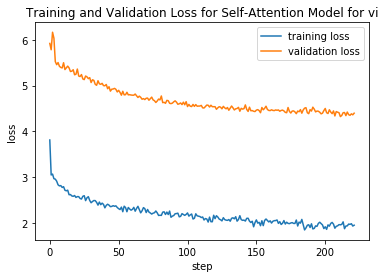

In [18]:
plt.plot(plot_losses,label="training loss")
plt.plot(val_losses,label="validation loss")
plt.title("Training and Validation Loss for Self-Attention Model for vi")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.savefig("self_attn_vi_new.png")
plt.show()

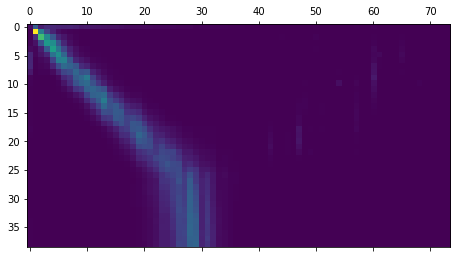

In [27]:
choice = random.randint(0, len(attention_list)-1)
plt.matshow(attention_list[choice].cpu().numpy())
plt.savefig("self_attn_vi_attn_new.png")
plt.show()